In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


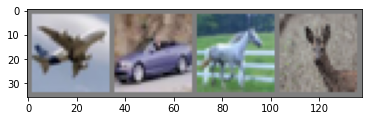

plane   car horse  deer


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
class LabelSmoothingLoss(nn.Module): 
    def __init__(self, classes, smoothing=0.0, dim=-1): 
        super(LabelSmoothingLoss, self).__init__() 
        self.confidence = 1.0 - smoothing 
        self.smoothing = smoothing 
        self.cls = classes 
        self.dim = dim 

    def forward(self, pred, target): 
        pred = pred.log_softmax(dim=self.dim) 
        with torch.no_grad(): 
            # true_dist = pred.data.clone() 
            true_dist = torch.zeros_like(pred) 
            true_dist.fill_(self.smoothing / (self.cls - 1)) 
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) 

        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))


In [6]:
target = torch.tensor([6, 0, 1, 4])
target = target.view(2,-1)
target
# target.data.unsqueeze(1)

tensor([[6, 0],
        [1, 4]])

In [7]:
true_dist = torch.zeros_like(torch.randn([2,10])) 
true_dist.fill_(0.01) 
true_dist.scatter_(1, target.data, 0.8) 
true_dist

tensor([[0.8000, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.8000, 0.0100, 0.0100,
         0.0100],
        [0.0100, 0.8000, 0.0100, 0.0100, 0.8000, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100]])

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
criterion = LabelSmoothingLoss(classes=10)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [9]:
def test() :
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
#             _, c, h, w = (images.shape)
#             images = torch.cat([images, images], dim=0).view(-1, 2*c, h, w)
    #         print(images.shape)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

In [10]:
for epoch in range(40):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    test()

print('Finished Training')

[1,  2000] loss: 1.860
[1,  4000] loss: 1.612
[1,  6000] loss: 1.499
[1,  8000] loss: 1.449
[1, 10000] loss: 1.426
[1, 12000] loss: 1.385
Accuracy of the network on the 10000 test images: 51 %
[2,  2000] loss: 1.316
[2,  4000] loss: 1.313
[2,  6000] loss: 1.291
[2,  8000] loss: 1.275
[2, 10000] loss: 1.280
[2, 12000] loss: 1.242
Accuracy of the network on the 10000 test images: 56 %
[3,  2000] loss: 1.206
[3,  4000] loss: 1.170
[3,  6000] loss: 1.209
[3,  8000] loss: 1.170
[3, 10000] loss: 1.189
[3, 12000] loss: 1.180
Accuracy of the network on the 10000 test images: 57 %
[4,  2000] loss: 1.087
[4,  4000] loss: 1.128
[4,  6000] loss: 1.118
[4,  8000] loss: 1.132
[4, 10000] loss: 1.162
[4, 12000] loss: 1.118
Accuracy of the network on the 10000 test images: 58 %
[5,  2000] loss: 1.054
[5,  4000] loss: 1.063
[5,  6000] loss: 1.062
[5,  8000] loss: 1.109
[5, 10000] loss: 1.062
[5, 12000] loss: 1.092
Accuracy of the network on the 10000 test images: 59 %
[6,  2000] loss: 1.006
[6,  4000] l

In [11]:
# correct = 0
# total = 0
# # since we're not training, we don't need to calculate the gradients for our outputs
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         # calculate outputs by running images through the network
#         outputs = net(images)
#         # the class with the highest energy is what we choose as prediction
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print('Accuracy of the network on the 10000 test images: %d %%' % (
#     100 * correct / total))